In [4]:
import pystac_client
import planetary_computer
import geopandas as gpd
import stackstac
import rasterio
from rasterio.merge import merge
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from rasterio import mask
from rasterio import plot
import shapely

In [5]:
ast_data = gpd.read_file("/hpc/group/borsuklab/ast/tile_level_annotation_multiple_capture_date_neighbor_tile_removed/tile_level_annotation_multiple_capture_date_neighbor_tile_removed.geojson")

In [125]:
# load catalog
collection = "3dep-lidar-hag"
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                     modifier=planetary_computer.sign_inplace,)

In [149]:
#get information for the full collection
asset = catalog.get_collection(collection).assets["geoparquet-items"]
#read into pandas
df = gpd.read_parquet(asset.href, storage_options=asset.extra_fields["table:storage_options"])
df["url"] = df["assets"].apply(lambda asset: asset["data"]["href"]) #create url 

storage_tank_asset_information = gpd.sjoin(ast_data, df)
storage_tank_asset_information = storage_tank_asset_information.rename(columns={"id_left": "tank_id"})
storage_tank_asset_information = storage_tank_asset_information[["tank_id","object_class","url"]]

In [151]:
tank_grouped_asset_information = storage_tank_asset_information.groupby(by="tank_id")

In [153]:
for tank_id, df in tank_grouped_asset_information:
    

In [21]:
geometry = ast_data.geometry[0]#.buffer(0.1) #possibly include buffer
search = catalog.search(collections=["3dep-lidar-hag"], 
                        intersects=geometry)
ic = search.item_collection()

In [87]:
minx, miny, maxx, maxy = ast_data.iloc[0][['nw_x_utm_object_coord','se_y_utm_object_coord', 'se_x_utm_object_coord','nw_y_utm_object_coord']]
geometry = shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
geometry.bounds

(606104.1000000001, 4497929.7, 606145.5, 4497970.5)

In [106]:
for raster in rasters:
    clipped_image, clipped_transform = rasterio.mask.mask(raster, [geometry], crop=True)
    #clipped_image = clipped_image.squeeze()
    #clipped_image.shape
    height = np.quantile(masked_arr.data.flatten(), 0.9)


In [108]:

mask = clipped_image == -9999
masked_arr = np.ma.masked_where(mask, clipped_image).squeeze()

(array([ 92.,  14.,  18.,  13.,  18.,  15.,  17.,  21.,  43., 190.]),
 array([-8.44098104e-04,  1.48724031e+00,  2.97532463e+00,  4.46340895e+00,
         5.95149374e+00,  7.43957806e+00,  8.92766285e+00,  1.04157467e+01,
         1.19038315e+01,  1.33919153e+01,  1.48800001e+01]),
 <BarContainer object of 10 artists>)

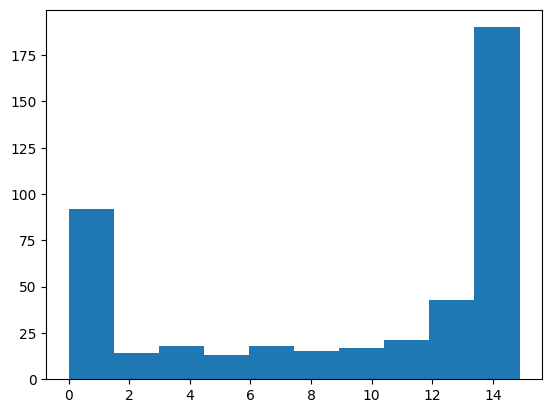

In [118]:
plt.hist(masked_arr.flatten())

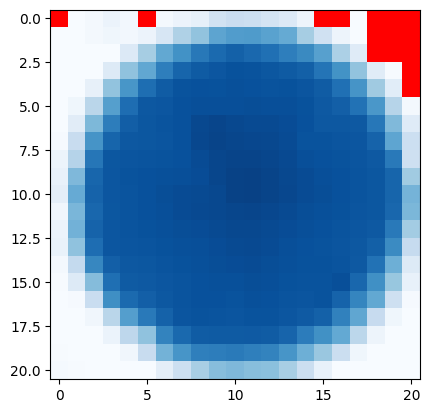

In [115]:
cmap = plt.cm.Blues

plt.imshow(masked_arr, vmin =0, vmax=16,cmap=cmap)

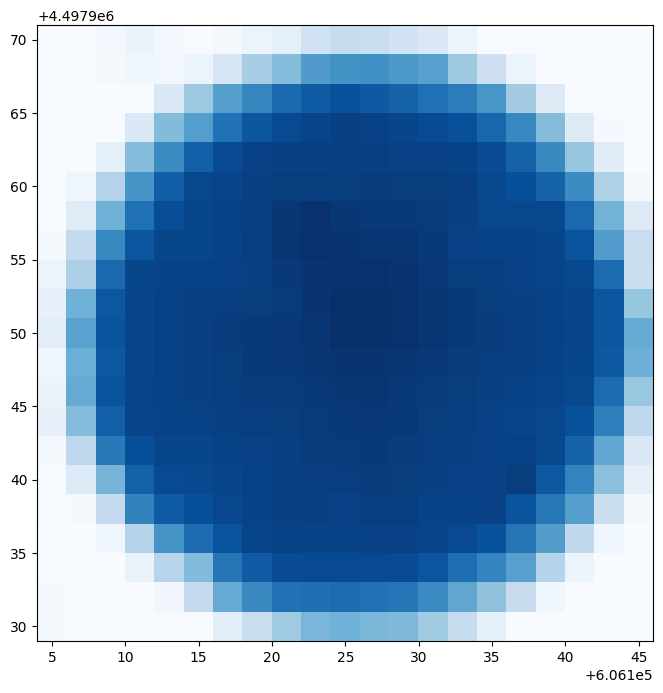

In [103]:
# Create a sequential colormap

# Set values below 0 to gray
#cmap.set_bad(color='red')
cmap.set_under('red', alpha=1.0)

fig, ax = plt.subplots(figsize=(8, 8))

plot.show(clipped_image, transform=clipped_transform, cmap=cmap)
ax.set_axis_off()

In [63]:
raster_paths = [i.assets["data"].href for i in ic]
rasters = [rasterio.open(raster_path) for raster_path in raster_paths]
assert [raster.nodata == -9999 for raster in rasters]

#merge neighbooring tiles if needed
merged, transform = merge(rasters)
                          
# Create a mask for where arr == -999

# Apply the mask to the array to get masked array 
masked_arr = np.ma.masked_where(mask, merged).squeeze()

In [69]:
geometry.bounds

(-73.74546589029443, 40.625390759429486, -73.74499736605846, 40.62575258693307)

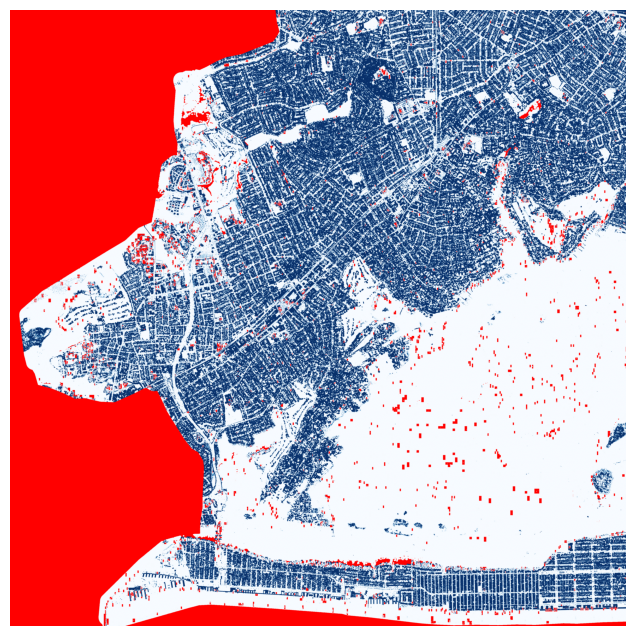

11540    {'data': {'href': 'https://usgslidareuwest.blo...
Name: assets, dtype: object

Define some variables we will use for querying

In [ ]:
conda install --channel conda-forge pdal

Define a PDAL reader using readers.copc for each tile
url is a signed, HTTP-able URL we can read from
requests is the number of threads to use. We need to use a much smaller number than the default 15
resolution is the floor'd resolution of the data. Resolution is not exact, and it depends up on the structure and breakpoints of the octree when the COPC file was built. Setting it to a value means the points that are returned at least meet that resolution
polygon is a WKT or GeoJSON geometry that will act to both pre-filter the selection of the data from the COPC file and clip the data as they are read.

In [ ]:
readers = []
for tile in ic:
    url = tile.assets["data"].href
    reader = pdal.Reader.copc(
        url, requests=3, resolution=READ_RESOLUTION, polygon=polygon
    )
    readers.append(reader)

In [ ]:
# Gather up all of our readers and concatenate them together
pipeline = None

# Gather up all of our readers and concatenate them together
for reader in readers:
    if not pipeline:
        pipeline = reader
    else:
        pipeline = pipeline | reader

merge = pdal.Filter.merge()
hag = pdal.Filter.hag_nn()
writer = pdal.Writer.gdal(
    "hag.tif",
    resolution=OUTPUT_RESOLUTION,
    dimension="HeightAboveGround",
    data_type="float32",
    output_type="mean",
)


pipeline = pipeline | merge | hag | writer

p = pipeline.execute()

In [ ]:
rasterio.imshow(cmap(ds), cmap=cmap)
ax.set_axis_off()

In [94]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import glob

In [68]:

out_meta = rasters[0].meta.copy()
out_meta.update({"driver": "GTiff",  
                 "height": merged.shape[1],
                 "width": merged.shape[2],
                 "transform": out_trans})

with rasterio.open('merged.tif', "w", **out_meta) as dest:
    dest.write(merged)

array([[ 9.4190758e-01,  1.0219076e+00,  7.6190758e-01, ...,
         1.0000000e+00,  6.6000003e-01,  3.4000000e-01],
       [ 3.1819077e+00,  2.9019077e+00,  3.0819075e+00, ...,
         3.5400000e+00,  3.0200000e+00,  2.5000000e+00],
       [ 4.5619078e+00,  4.0419078e+00,  3.6219077e+00, ...,
         4.6199999e+00,  4.4600000e+00,  4.3600001e+00],
       ...,
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [30]:
stack = stackstac.stack(items)

ValueError: Cannot pick a common CRS, since asset 'data' of item 0 'USGS_LPC_NY_LongIsland_Z18_2014_LAS_2015-hag-2m-1-9' does not have one.

Please specify a CRS with the `epsg=` argument.